In [1]:
import os
import scipy.io as io
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random
from scipy.spatial.transform import Rotation as R
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import cv2

np.random.seed(42)

# Load Dataset

In [2]:
dataset_dir = '/hdd/public_datasets/STHEREO'
seq = 'KAIST'
sequence_key = {'KAIST': ['01', '02', '03'], 'SNU': ['04', '05', '06'], 'Valley': ['07', '08', '09']}

dataset_path = [os.path.join(dataset_dir, index) for index in sequence_key[seq]]    
pose_path = [path + '/pose/global_pose.csv' for path in dataset_path]  
rgb_path = [path + '/image/stereo_left/' for path in dataset_path]   
thermal_path = [path + '/image/stereo_thermal_14_left/' for path in dataset_path]   

morning_pose_pd = pd.read_csv(pose_path[0], header=None)
afternoon_pose_pd = pd.read_csv(pose_path[1], header=None)
evening_pose_pd = pd.read_csv(pose_path[2], header=None)

# Set Parameters:   

In [3]:
DB_DIS_TH = 5
Query_DIS_TH = 1

# Create Morning Dataset

create /home/yeminghao/RBGT_loop/STHEREO_Mat/KAIST 


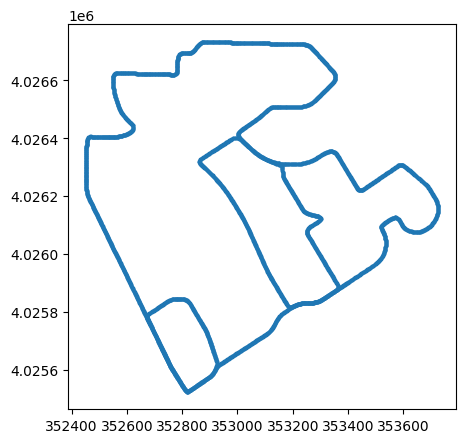

In [4]:
save_path = os.path.join('Your_Save_Path', seq)
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"create {save_path} ")

morning_pose_pd = morning_pose_pd.iloc[1:-1, :].reset_index(drop=True)
morning_pose_gt = morning_pose_pd.iloc[:, 1:3].to_numpy()
# print(morning_pose_gt.shape)
plt.rcParams['figure.figsize'] = (5, 5)
plt.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=3)
plt.show()

## Create Database

morning dataset has 4794 poses
morning database has 1152 poses


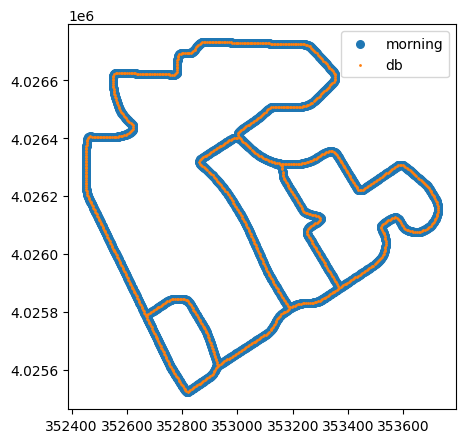

In [5]:
## create morning database

db_index = [0]
morning_db = morning_pose_gt[0, :].reshape(1, -1)  # add the first frame

for i in range(1, morning_pose_gt.shape[0]):
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(morning_db[:, 0:2])
    dis, index = knn.kneighbors(morning_pose_gt[i, 0:2].reshape(1, -1), 1, return_distance=True)

    if dis > DB_DIS_TH:
        morning_db = np.concatenate((morning_db, morning_pose_gt[i, :].reshape(1, -1)), axis=0)
        db_index.append(i)

print(f"morning dataset has {morning_pose_gt.shape[0]} poses")
print(f"morning database has {morning_db.shape[0]} poses")

plt.rcParams['figure.figsize'] = (5, 5)
plt.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='morning')
plt.scatter(morning_db[:, 0], morning_db[:, 1], s=1, label='db')
plt.legend()
plt.show()

In [6]:
morning_rgb_list = []
for filename in os.listdir(rgb_path[0]):
    if filename.endswith('.png'):
        name_without_extension = os.path.splitext(filename)[0]
        morning_rgb_list.append(name_without_extension)

morning_t_list = []
for filename in os.listdir(thermal_path[0]):
    if filename.endswith('.png'):
        name_without_extension = os.path.splitext(filename)[0]
        morning_t_list.append(name_without_extension)

morning_rgb_list.sort()
morning_t_list.sort()

morning_rgb_time = np.array(morning_rgb_list).astype(np.int64)* 10e-10  
morning_t_time = np.array(morning_t_list).astype(np.int64)* 10e-10
morning_db_time = morning_pose_pd.iloc[db_index, 0].to_numpy()

distances = np.abs(morning_rgb_time[:, np.newaxis] - morning_db_time)
morning_db_rgb_index = np.argmin(distances, axis=0)
morning_db_rgb = [rgb_path[0] + morning_rgb_list[i] + '.png' for i in morning_db_rgb_index]

distances = np.abs(morning_t_time[:, np.newaxis] - morning_db_time)
morning_db_t_index = np.argmin(distances, axis=0)
morning_db_t = [thermal_path[0] + morning_t_list[i] + '.png' for i in morning_db_t_index]

print(len(morning_db_rgb), len(morning_db_t), morning_db.shape[0])
assert len(morning_db_rgb) == len(morning_db_t) == morning_db.shape[0]
# ## Visualization
# random_index = np.random.randint(0, len(morning_db_t))

# img1 = cv2.imread(morning_db_rgb[random_index], cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread(dataset_dir + morning_db_t[random_index], cv2.IMREAD_UNCHANGED)
# # img2 = cv2.imread(morning_db_rgb[random_index+10], cv2.IMREAD_GRAYSCALE)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BAYER_RG2RGB)
# img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# # img2 = cv2.cvtColor(img2, cv2.COLOR_BAYER_RG2RGB)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.imshow(img1)
# ax1.axis('off')  
# ax1.set_title('Database rgb')
# ax2.imshow(img2, cmap='gray')
# ax2.axis('off')  
# ax2.set_title('Database T')
# plt.tight_layout()
# plt.show()

1152 1152 1152


## Create Query

<Figure size 1500x500 with 0 Axes>

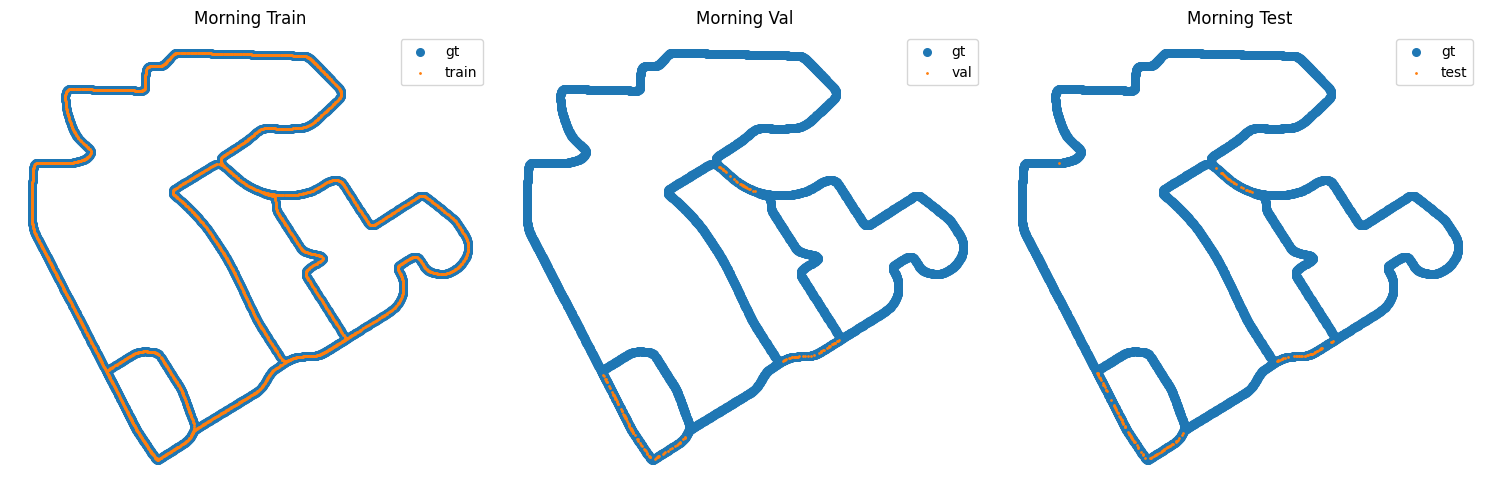

Morining Train NUM 3337


In [7]:
## create morning query
morning_index = [i for i in range(morning_pose_gt.shape[0])]
morning_index = list(set(morning_index) - set(db_index))

morning_train_index = [morning_index[0]]
morning_train_pose = morning_pose_gt[morning_train_index, :].reshape(1, -1)  # add the first frame

for i in range(1, morning_pose_gt.shape[0]):
    if i not in db_index:
        knn = NearestNeighbors(n_neighbors=1)
        knn.fit(morning_train_pose[:, 0:2])
        dis, index = knn.kneighbors(morning_pose_gt[i, 0:2].reshape(1, -1), 1, return_distance=True)
    
        if dis > Query_DIS_TH:
            morning_train_pose = np.concatenate((morning_train_pose, morning_pose_gt[i, :].reshape(1, -1)), axis=0)
            morning_train_index.append(i)

train_q_index = morning_train_index

index = list(set(morning_index) - set(train_q_index))

val_q_num = int(len(index) *0.5)

val_q_index = np.random.choice(list(set(morning_index)-set(train_q_index)), val_q_num, replace=False)
test_q_index = list(set(morning_index) - set(train_q_index) - set(val_q_index))

plt.figure(figsize=(15, 5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax1.scatter(morning_pose_gt[train_q_index, 0], morning_pose_gt[train_q_index, 1], s=1, label='train')
ax1.legend()
ax1.axis('off') 
ax1.set_title('Morning Train')
ax2.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax2.scatter(morning_pose_gt[val_q_index, 0], morning_pose_gt[val_q_index, 1], s=1, label='val')
ax2.legend()
ax2.axis('off') 
ax2.set_title('Morning Val')
ax3.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax3.scatter(morning_pose_gt[test_q_index, 0], morning_pose_gt[test_q_index, 1], s=1, label='test')
ax3.legend()
ax3.axis('off') 
ax3.set_title('Morning Test')
plt.tight_layout()
plt.show()

print('Morining Train NUM', len(morning_train_index))

In [8]:
# get train image
morning_query_time = morning_pose_pd.iloc[train_q_index, 0].to_numpy()
distances = np.abs(morning_rgb_time[:, np.newaxis] - morning_query_time)
morning_q_rgb_index = np.argmin(distances, axis=0)
morning_q_rgb_train = [os.path.join(rgb_path[0], morning_rgb_list[i]) + '.png' for i in morning_q_rgb_index]

distances = np.abs(morning_t_time[:, np.newaxis] - morning_query_time)
morning_q_t_index = np.argmin(distances, axis=0)
morning_q_t_train = [os.path.join(thermal_path[0], morning_t_list[i]) + '.png' for i in morning_q_t_index]

morning_q_pose_train = morning_pose_gt[train_q_index,:]

print(morning_q_rgb_train[0])
print(morning_q_t_train[0])
# get val image
morning_query_time = morning_pose_pd.iloc[val_q_index, 0].to_numpy()
distances = np.abs(morning_rgb_time[:, np.newaxis] - morning_query_time)
morning_q_rgb_index = np.argmin(distances, axis=0)
morning_q_rgb_val = [os.path.join(rgb_path[0], morning_rgb_list[i]) + '.png' for i in morning_q_rgb_index]

distances = np.abs(morning_t_time[:, np.newaxis] - morning_query_time)
morning_q_t_index = np.argmin(distances, axis=0)
morning_q_t_val = [os.path.join(thermal_path[0], morning_t_list[i]) + '.png' for i in morning_q_t_index]

morning_q_pose_val = morning_pose_gt[val_q_index,:]

# get test image
morning_query_time = morning_pose_pd.iloc[test_q_index, 0].to_numpy()
distances = np.abs(morning_rgb_time[:, np.newaxis] - morning_query_time)
morning_q_rgb_index = np.argmin(distances, axis=0)
morning_q_rgb_test = [os.path.join(rgb_path[0], morning_rgb_list[i]) + '.png' for i in morning_q_rgb_index]

distances = np.abs(morning_t_time[:, np.newaxis] - morning_query_time)
morning_q_t_index = np.argmin(distances, axis=0)
morning_q_t_test = [os.path.join(thermal_path[0], morning_t_list[i]) + '.png' for i in morning_q_t_index]

morning_q_pose_test = morning_pose_gt[test_q_index,:]

print(len(morning_q_rgb_train), len(morning_q_t_train), len(morning_q_pose_train))
print(len(morning_q_rgb_val), len(morning_q_t_val), len(morning_q_pose_val))
print(len(morning_q_rgb_test), len(morning_q_t_test), len(morning_q_pose_test))

/hdd/public_datasets/STHEREO/01/image/stereo_left/1630106856699247344.png
/hdd/public_datasets/STHEREO/01/image/stereo_thermal_14_left/1630106856618120598.png
3337 3337 3337
152 152 152
153 153 153


<Figure size 1500x500 with 0 Axes>

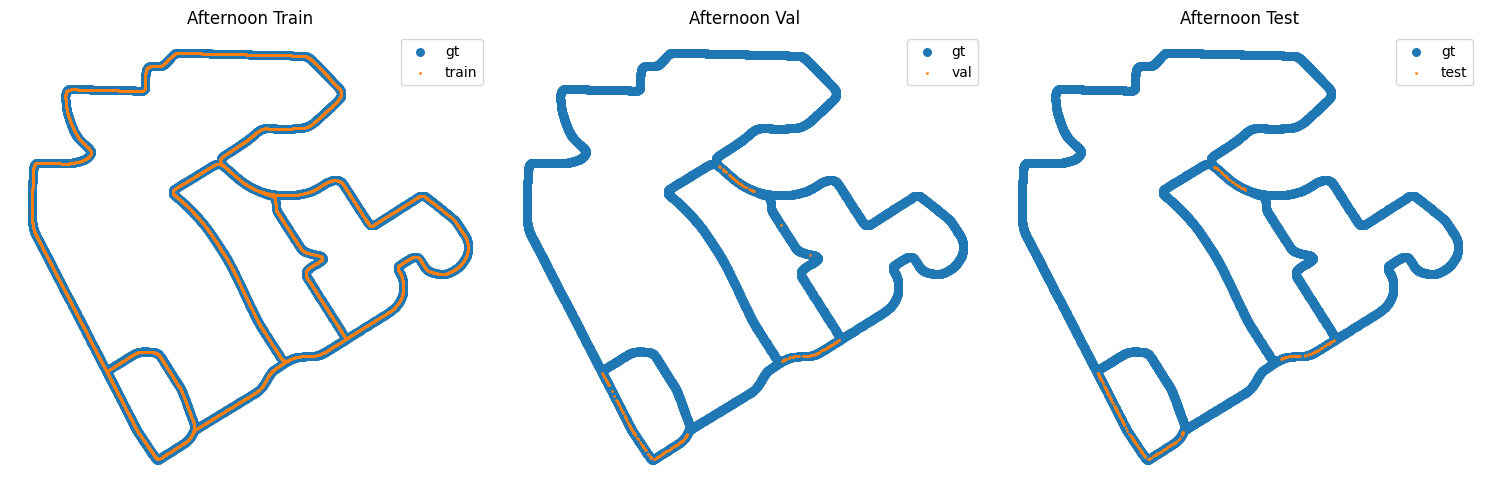

Afternoon Train NUM 4781


In [9]:
## create afternoon query
afternoon_pose_pd = afternoon_pose_pd.iloc[1:-1, :].reset_index(drop=True)
afternoon_pose_gt = afternoon_pose_pd.iloc[:, 1:3].to_numpy()
afternoon_index = [i for i in range(afternoon_pose_gt.shape[0])]

afternoon_train_index = [0]
afternoon_train_pose = afternoon_pose_gt[0, :].reshape(1, -1)  # add the first frame

for i in range(1, afternoon_pose_gt.shape[0]):
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(afternoon_train_pose[:, 0:2])
    dis, index = knn.kneighbors(afternoon_pose_gt[i, 0:2].reshape(1, -1), 1, return_distance=True)

    if dis > Query_DIS_TH:
        afternoon_train_pose = np.concatenate((afternoon_train_pose, afternoon_pose_gt[i, :].reshape(1, -1)), axis=0)
        afternoon_train_index.append(i)

train_q_index = afternoon_train_index

index = list(set(afternoon_index)- set(train_q_index))
val_q_num = int(len(index) *0.5)


val_q_index = np.random.choice(index, val_q_num, replace=False)
test_q_index = list(set(index)- set(val_q_index))

plt.figure(figsize=(15, 5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax1.scatter(afternoon_pose_gt[train_q_index, 0], afternoon_pose_gt[train_q_index, 1], s=1, label='train')
ax1.legend()
ax1.axis('off') 
ax1.set_title('Afternoon Train')
ax2.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax2.scatter(afternoon_pose_gt[val_q_index, 0], afternoon_pose_gt[val_q_index, 1], s=1, label='val')
ax2.legend()
ax2.axis('off') 
ax2.set_title('Afternoon Val')
ax3.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax3.scatter(afternoon_pose_gt[test_q_index, 0], afternoon_pose_gt[test_q_index, 1], s=1, label='test')
ax3.legend()
ax3.axis('off') 
ax3.set_title('Afternoon Test')
plt.tight_layout()
plt.show()

print('Afternoon Train NUM', len(afternoon_train_index))

In [10]:
afternoon_rgb_list = []
for filename in os.listdir(rgb_path[1]):
    if filename.endswith('.png'):
        # 去掉文件后缀并存入列表
        name_without_extension = os.path.splitext(filename)[0]
        afternoon_rgb_list.append(name_without_extension)

afternoon_t_list = []
for filename in os.listdir(thermal_path[1]):
    if filename.endswith('.png'):
        # 去掉文件后缀并存入列表
        name_without_extension = os.path.splitext(filename)[0]
        afternoon_t_list.append(name_without_extension)

afternoon_rgb_list.sort()
afternoon_t_list.sort()
afternoon_rgb_time = np.array(afternoon_rgb_list).astype(np.int64)* 10e-10  # 这样操作的时间戳精度有下降，但是理论上应该还是够用的？
afternoon_t_time = np.array(afternoon_t_list).astype(np.int64)* 10e-10

# get train image
afternoon_query_time = afternoon_pose_pd.iloc[train_q_index, 0].to_numpy()
distances = np.abs(afternoon_rgb_time[:, np.newaxis] - afternoon_query_time)
afternoon_q_rgb_index = np.argmin(distances, axis=0)
afternoon_q_rgb_train = [os.path.join(rgb_path[1], afternoon_rgb_list[i]) + '.png' for i in afternoon_q_rgb_index]

distances = np.abs(afternoon_t_time[:, np.newaxis] - afternoon_query_time)
afternoon_q_t_index = np.argmin(distances, axis=0)
afternoon_q_t_train = [os.path.join(thermal_path[1], afternoon_t_list[i]) + '.png' for i in afternoon_q_t_index]

afternoon_q_pose_train = afternoon_pose_gt[train_q_index,:]

# get val image
afternoon_query_time = afternoon_pose_pd.iloc[val_q_index, 0].to_numpy()
distances = np.abs(afternoon_rgb_time[:, np.newaxis] - afternoon_query_time)
afternoon_q_rgb_index = np.argmin(distances, axis=0)
afternoon_q_rgb_val = [os.path.join(rgb_path[1], afternoon_rgb_list[i]) + '.png' for i in afternoon_q_rgb_index]

distances = np.abs(afternoon_t_time[:, np.newaxis] - afternoon_query_time)
afternoon_q_t_index = np.argmin(distances, axis=0)
afternoon_q_t_val = [os.path.join(thermal_path[1], afternoon_t_list[i]) + '.png' for i in afternoon_q_t_index]

afternoon_q_pose_val = afternoon_pose_gt[val_q_index,:]


# get test image
afternoon_query_time = afternoon_pose_pd.iloc[test_q_index, 0].to_numpy()
distances = np.abs(afternoon_rgb_time[:, np.newaxis] - afternoon_query_time)
afternoon_q_rgb_index = np.argmin(distances, axis=0)
afternoon_q_rgb_test = [os.path.join(rgb_path[1], afternoon_rgb_list[i]) + '.png' for i in afternoon_q_rgb_index]

distances = np.abs(afternoon_t_time[:, np.newaxis] - afternoon_query_time)
afternoon_q_t_index = np.argmin(distances, axis=0)
afternoon_q_t_test = [os.path.join(thermal_path[1], afternoon_t_list[i]) + '.png' for i in afternoon_q_t_index]

afternoon_q_pose_test = afternoon_pose_gt[test_q_index,:]

print(len(afternoon_q_rgb_train), len(afternoon_q_t_train), len(afternoon_q_pose_train))
print(len(afternoon_q_rgb_val), len(afternoon_q_t_val), len(afternoon_q_pose_val))
print(len(afternoon_q_rgb_test), len(afternoon_q_t_test), len(afternoon_q_pose_test))

4781 4781 4781
240 240 240
241 241 241


<Figure size 1500x500 with 0 Axes>

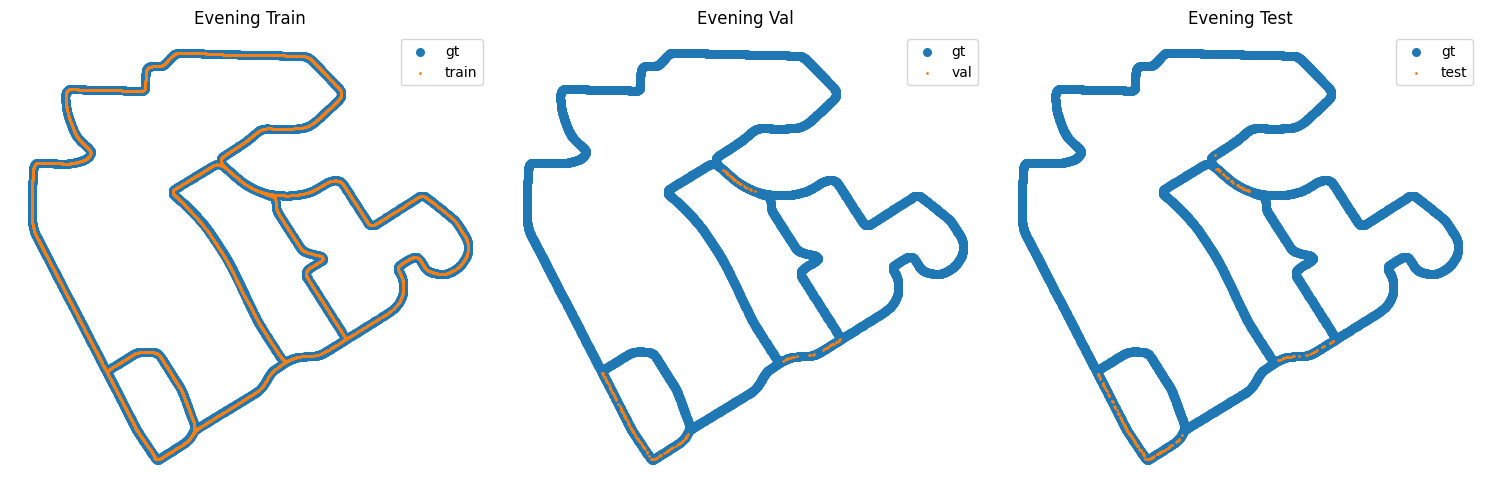

Evening Train NUM 4430


In [11]:
## create Evening query
evening_pose_pd = evening_pose_pd.iloc[1:-1, :].reset_index(drop=True)
evening_pose_gt = evening_pose_pd.iloc[:, 1:3].to_numpy()
evening_index = [i for i in range(evening_pose_gt.shape[0])]

evening_train_index = [0]
evening_train_pose = evening_pose_gt[0, :].reshape(1, -1)  # add the first frame

for i in range(1, evening_pose_gt.shape[0]):
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(evening_train_pose[:, 0:2])
    dis, index = knn.kneighbors(evening_pose_gt[i, 0:2].reshape(1, -1), 1, return_distance=True)

    if dis > Query_DIS_TH:
        evening_train_pose = np.concatenate((evening_train_pose, evening_pose_gt[i, :].reshape(1, -1)), axis=0)
        evening_train_index.append(i)

train_q_index = evening_train_index

index = list(set(evening_index)- set(train_q_index))
val_q_num = int(len(index) *0.5)

val_q_index = np.random.choice(index, val_q_num, replace=False)
test_q_index = list(set(index) - set(val_q_index))

plt.figure(figsize=(15, 5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax1.scatter(evening_pose_gt[train_q_index, 0], evening_pose_gt[train_q_index, 1], s=1, label='train')
ax1.legend()
ax1.axis('off') 
ax1.set_title('Evening Train')
ax2.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax2.scatter(evening_pose_gt[val_q_index, 0], evening_pose_gt[val_q_index, 1], s=1, label='val')
ax2.legend()
ax2.axis('off') 
ax2.set_title('Evening Val')
ax3.scatter(morning_pose_gt[:, 0], morning_pose_gt[:, 1], s=30, label='gt')
ax3.scatter(evening_pose_gt[test_q_index, 0], evening_pose_gt[test_q_index, 1], s=1, label='test')
ax3.legend()
ax3.axis('off') 
ax3.set_title('Evening Test')
plt.tight_layout()
plt.show()

print('Evening Train NUM', len(evening_train_index))

In [12]:
evening_rgb_list = []
for filename in os.listdir(rgb_path[2]):
    if filename.endswith('.png'):
        name_without_extension = os.path.splitext(filename)[0]
        evening_rgb_list.append(name_without_extension)

evening_t_list = []
for filename in os.listdir(thermal_path[2]):
    if filename.endswith('.png'):
        name_without_extension = os.path.splitext(filename)[0]
        evening_t_list.append(name_without_extension)

evening_rgb_list.sort()
evening_t_list.sort()
evening_rgb_time = np.array(evening_rgb_list).astype(np.int64)* 10e-10  
evening_t_time = np.array(evening_t_list).astype(np.int64)* 10e-10

# get train image
evening_query_time = evening_pose_pd.iloc[train_q_index, 0].to_numpy()
distances = np.abs(evening_rgb_time[:, np.newaxis] - evening_query_time)
evening_q_rgb_index = np.argmin(distances, axis=0)
evening_q_rgb_train = [os.path.join(rgb_path[2], evening_rgb_list[i]) + '.png' for i in evening_q_rgb_index]

distances = np.abs(evening_t_time[:, np.newaxis] - evening_query_time)
evening_q_t_index = np.argmin(distances, axis=0)
evening_q_t_train = [os.path.join(thermal_path[2], evening_t_list[i]) + '.png' for i in evening_q_t_index]

evening_q_pose_train = evening_pose_gt[train_q_index,:]

# get val image
evening_query_time = evening_pose_pd.iloc[val_q_index, 0].to_numpy()
distances = np.abs(evening_rgb_time[:, np.newaxis] - evening_query_time)
evening_q_rgb_index = np.argmin(distances, axis=0)
evening_q_rgb_val = [os.path.join(rgb_path[2], evening_rgb_list[i]) + '.png' for i in evening_q_rgb_index]

distances = np.abs(evening_t_time[:, np.newaxis] - evening_query_time)
evening_q_t_index = np.argmin(distances, axis=0)
evening_q_t_val = [os.path.join(thermal_path[2], evening_t_list[i]) + '.png' for i in evening_q_t_index]

evening_q_pose_val = evening_pose_gt[val_q_index,:]

# get test image
evening_query_time = evening_pose_pd.iloc[test_q_index, 0].to_numpy()
distances = np.abs(evening_rgb_time[:, np.newaxis] - evening_query_time)
evening_q_rgb_index = np.argmin(distances, axis=0)
evening_q_rgb_test = [os.path.join(rgb_path[2], evening_rgb_list[i]) + '.png' for i in evening_q_rgb_index]

distances = np.abs(evening_t_time[:, np.newaxis] - evening_query_time)
evening_q_t_index = np.argmin(distances, axis=0)
evening_q_t_test = [os.path.join(thermal_path[2], evening_t_list[i]) + '.png' for i in evening_q_t_index]

evening_q_pose_test = evening_pose_gt[test_q_index,:]

print(len(evening_q_rgb_train), len(evening_q_t_train), len(evening_q_pose_train))
print(len(evening_q_rgb_val), len(evening_q_t_val), len(evening_q_pose_val))
print(len(evening_q_rgb_test), len(evening_q_t_test), len(evening_q_pose_test))

4430 4430 4430
174 174 174
175 175 175


## Generate File 

In [13]:
posDistThr = 18
posDistSqThr = posDistThr**2
nonTrivPosDistSqThr = 9**2
# posDistThr, posDistSqThr, nonTrivPosDistSqThr are not used

dbStruct = {
    'whichSet': 'train',
    'db_rgb': morning_db_rgb,
    'db_t': morning_db_t,
    'db_pose': morning_db,
    'q_rgb_morning': morning_q_rgb_train,
    'q_t_morning': morning_q_t_train,
    'q_pose_morning': morning_q_pose_train,
    'q_rgb_afternoon': afternoon_q_rgb_train,
    'q_t_afternoon': afternoon_q_t_train,
    'q_pose_afternoon': afternoon_q_pose_train,
    'q_rgb_evening': evening_q_rgb_train,
    'q_t_evening': evening_q_t_train,
    'q_pose_evening': evening_q_pose_train,
    'numDB': len(morning_db_rgb),
    'numQ_morning': len(morning_q_rgb_train),
    'numQ_afternoon': len(afternoon_q_rgb_train),
    'numQ_evening': len(evening_q_rgb_train),
    'posDistThr': posDistThr,
    'posDistSqThr': posDistSqThr,
    'nonTrivPosDistSqThr': nonTrivPosDistSqThr
}
matfile = os.path.join(save_path,  'sthereo_train.mat')
io.savemat(matfile, {'dbStruct': dbStruct})

dbStruct = {
    'whichSet': 'val',
    'db_rgb': morning_db_rgb,
    'db_t': morning_db_t,
    'db_pose': morning_db,
    'q_rgb_morning': morning_q_rgb_val,
    'q_t_morning': morning_q_t_val,
    'q_pose_morning': morning_q_pose_val,
    'q_rgb_afternoon': afternoon_q_rgb_val,
    'q_t_afternoon': afternoon_q_t_val,
    'q_pose_afternoon': afternoon_q_pose_val,
    'q_rgb_evening': evening_q_rgb_val,
    'q_t_evening': evening_q_t_val,
    'q_pose_evening': evening_q_pose_val,
    'numDB': len(morning_db_rgb),
    'numQ_morning': len(morning_q_rgb_val),
    'numQ_afternoon': len(afternoon_q_rgb_val),
    'numQ_evening': len(evening_q_rgb_val),
    'posDistThr': posDistThr,
    'posDistSqThr': posDistSqThr,
    'nonTrivPosDistSqThr': nonTrivPosDistSqThr
}
matfile = os.path.join(save_path,  'sthereo_val.mat')
io.savemat(matfile, {'dbStruct': dbStruct})

dbStruct = {
    'whichSet': 'test',
    'db_rgb': morning_db_rgb,
    'db_t': morning_db_t,
    'db_pose': morning_db,
    'q_rgb_morning': morning_q_rgb_test,
    'q_t_morning': morning_q_t_test,
    'q_pose_morning': morning_q_pose_test,
    'q_rgb_afternoon': afternoon_q_rgb_test,
    'q_t_afternoon': afternoon_q_t_test,
    'q_pose_afternoon': afternoon_q_pose_test,
    'q_rgb_evening': evening_q_rgb_test,
    'q_t_evening': evening_q_t_test,
    'q_pose_evening': evening_q_pose_test,
    'numDB': len(morning_db_rgb),
    'numQ_morning': len(morning_q_rgb_test),
    'numQ_afternoon': len(afternoon_q_rgb_test),
    'numQ_evening': len(evening_q_rgb_test),
    'posDistThr': posDistThr,
    'posDistSqThr': posDistSqThr,
    'nonTrivPosDistSqThr': nonTrivPosDistSqThr
}
matfile = os.path.join(save_path,  'sthereo_test.mat')
io.savemat(matfile, {'dbStruct': dbStruct})